In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
from models import LinearReg
from models import Dataprocessor
from models import NeuralNetwork
import numpy as np

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# paso las areas todas a m2 y saco el tipo de medida ya que es redundante luego de pasar todo a m2
# manejo los nans reemplazando por media y mediana dependiendo si son binarias o continuas
# normalizo los datos

df_dev = pd.read_csv("../data/raw/casas_dev.csv")
dp_dev = Dataprocessor(df_dev)
dp_dev.set_area_units()
dp_dev.handle_missing_values()
dp_dev.normalize()
df_dev_p = dp_dev.get_data()



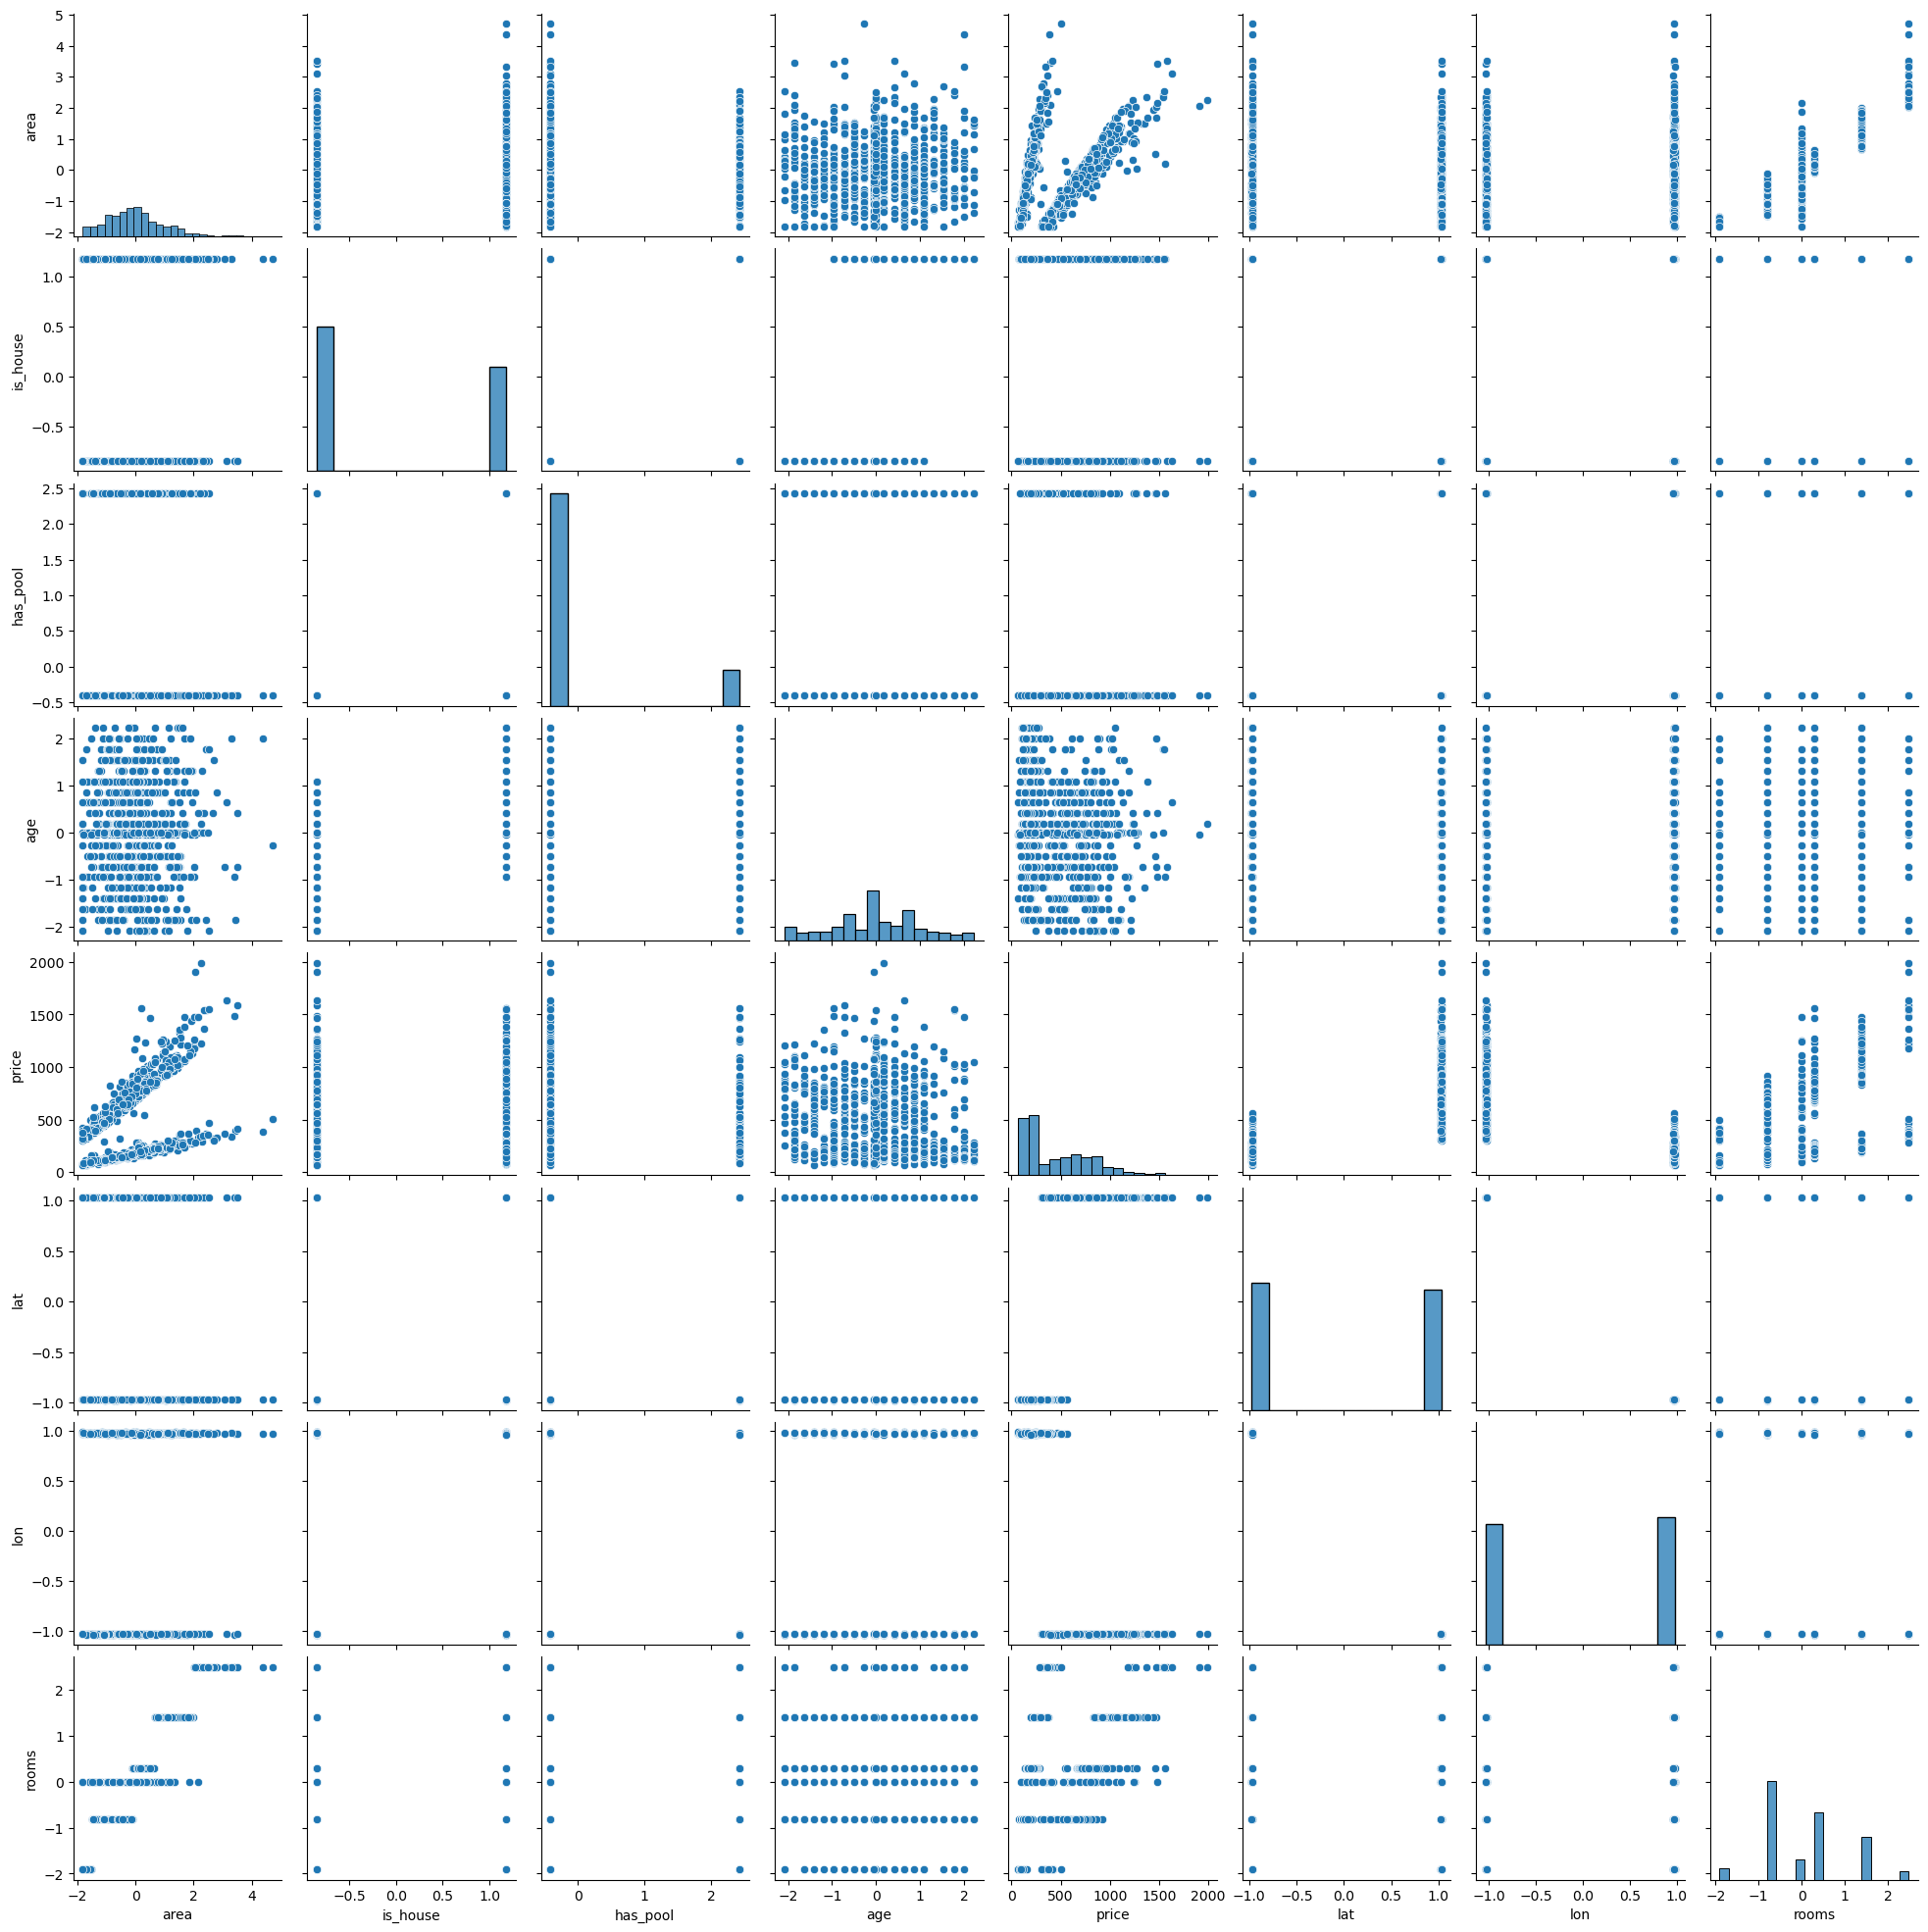

In [3]:
sns.pairplot(df_dev_p)
plt.show()

In [4]:


#spliteo el raw data para que cuando normalice no haga data leakage
df_train = df_dev.sample(frac=0.8)
df_val = df_dev.drop(df_train.index)

dp_train = Dataprocessor(df_train)
dp_train.set_area_units()
dp_train.handle_missing_values()
dp_train.normalize()
df_train = dp_train.get_data()

dp_val = Dataprocessor(df_val)
dp_val.set_area_units()
dp_val.handle_missing_values()
df_val = dp_val.get_data()

# normalizo con el data processor de train para usar sus mean y std y no hacer data leakage 
df_val = dp_train.normalize_new_data(df_val)

feature_names = df_train.columns
feature_names = feature_names.drop("price")
feature_names = ['bias'] + list(feature_names)

In [5]:
#caso simpe una sola feature
X_train = df_train["area"].values
Y_train = df_train["price"].values
Y_val = df_val["price"].values
X_val = df_val["area"].values
model = LinearReg(X_train, Y_train)
model.train_gd(0.01, 1000)
w = model.print_W(feature_names)
predict = model.predict(X_val)
print("el mse es de: ",model.mean_squared_error(Y_val, predict))

bias: 466.8819436586975
area: -233.8559550276603
el mse es de:  70348.19576738033


In [6]:
#caso una feature con pinv
model.train_pinv()
w = model.print_W(feature_names)
predict = model.predict(X_val)
print("el mse es de: ",model.mean_squared_error(Y_val, predict))

bias: 466.8819444444446
area: -233.85595543254732
el mse es de:  70348.19579699691


In [7]:
#caso multiple features
X_train = df_train.drop(columns=['price']).values
Y_train = df_train['price'].values
Y_val = df_val['price'].values
X_val = df_val.drop(columns=['price']).values
model = LinearReg(X_train, Y_train)
model.train_gd(0.1,1000)
w=model.print_W(feature_names)
predict = model.predict(X_val)
print("el mse es de: ",model.mean_squared_error(Y_val, predict))

bias: 466.8819444444444
area: -196.16807860024596
is_house: 32.22353140122664
has_pool: 14.34487143243561
age: -12.064869178157759
lat: 65.57963211613071
lon: -64.66415524372752
rooms: 197.56398301443292
el mse es de:  14396.586298436256


In [8]:
#caso multiple features con pinv
model.train_pinv()
model.print_W(feature_names)
predict = model.predict(X_val)
print("el mse es de: ",model.mean_squared_error(Y_val, predict))

bias: 466.88194444444446
area: -196.02485077783166
is_house: 32.27715900038969
has_pool: 14.315839412755194
age: -12.089829828653537
lat: 322.5365430663883
lon: 192.14925819655173
rooms: 197.56220077642882
el mse es de:  14411.874672558035


In [9]:
df_amanda = pd.read_csv("../data/raw/vivienda_Amanda.csv")
dp_a = Dataprocessor(df_amanda)
dp_a.set_area_units()
dp_a.handle_missing_values()
df_amanda_p = dp_train.normalize_new_data(dp_a.get_data()) #normalizo con el data processor de train para no hacer data leakage

In [10]:
# para intentar predecir el precio de la casa de amanda voy a entrenar con gd ya que me dio un mejor ecm
X_train = df_train.drop(columns=['price']).values
Y_train = df_train['price'].values
Y_val = df_val['price'].values
X_val = df_val.drop(columns=['price']).values
model = LinearReg(X_train, Y_train)
model.train_gd(0.01,1000)
w=model.print_W(feature_names)
X_amanda = df_amanda_p.values
predict = model.predict(X_amanda)
print("El precio de la casa de Amanda es de: ",predict[0])


bias: 466.8819436586974
area: -158.68054090847815
is_house: 33.33934274797339
has_pool: 14.309183459206155
age: -12.351607259495077
lat: 82.5962781193796
lon: -82.47413572985884
rooms: 185.04639792364756
El precio de la casa de Amanda es de:  492.33750859781406


In [12]:
# el peso de area seria el precio que varia entre dos casas con las mismas caracteristicas pero con distinta area, o tambien seria el precio/area promedio, pero este ultim no tiene en cuenta el ressto de caracteristicas lo voy a calcular de ambas maneras


sample_df = df_dev.copy()
dp=Dataprocessor(sample_df)
dp.set_area_units()
dp.handle_missing_values()
sample_df = dp.get_data()

casa_random = sample_df.sample()
casa_random.drop(columns="price",inplace=True)

casa_cmp = casa_random.copy()
casa_cmp["area"] = casa_random["area"] + 1

casa_random = dp_train.normalize_new_data(casa_random)
casa_cmp = dp_train.normalize_new_data(casa_cmp)
#uso el modelo entrenado con gd

price1 = model.predict(casa_random.values)
price2 = model.predict(casa_cmp.values)

print("El peso de area es de: ",price2-price1)

#ahora calculo el precio/area promedio
price_area = df_dev["price"].sum()/df_dev["area"].sum()
print("El precio/area promedio es de: ",price_area)


El peso de area es de:  [-3.22818321]
El precio/area promedio es de:  4.917970605966847


In [16]:
#nosotros podemos saber que si venito construye una pileta su casa aumentaria el valor ya que el peso que se le dio a la feature has_pool es positivo
print("la construccion de la pileta aumentaria el precio de la casa en: ",w[3])

la construccion de la pileta aumentaria el precio de la casa en:  12.112357395060679


In [13]:
# ahora para aplicar feature engineering
df_train_fe = df_train.copy()
df_val_fe = df_val.copy()
df_amanda_fe = df_amanda_p.copy()


#el resto de features propuestas solo subian el mse por lo que decidi no implementarlas
#viendo los graficos se notaba que en el 0 a la izquierda las casas seguian una tendencia de precio y a la derecha tambien asique decidi transformar la variable en binaria y quitar la lat y lon lo que bajo mi mse

df_train_fe["lat_bin"] = np.where(df_train_fe["lat"] >= 0, 1, 0)
df_val_fe["lat_bin"] = np.where(df_val_fe["lat"] >= 0, 1, 0)
df_train_fe["lon_bin"] = np.where(df_train_fe["lon"] >= 0, 1, 0)
df_val_fe["lon_bin"] = np.where(df_val_fe["lon"] >= 0, 1, 0)
df_amanda_fe["lat_bin"] = np.where(df_amanda_fe["lat"] >= 0, 1, 0)
df_amanda_fe["lon_bin"] = np.where(df_amanda_fe["lon"] >= 0, 1, 0)

# dropeo las columnas ya que la nueva variable lat_bin y lon_bin tienen que tener gran parte de la informacion por lo que vimos en el grafico entonces solo seria subir la dimensionalidad del problema
df_train_fe = df_train_fe.drop(columns=["lat"])
df_val_fe = df_val_fe.drop(columns=["lat"])
df_train_fe = df_train_fe.drop(columns=["lon"])
df_val_fe = df_val_fe.drop(columns=["lon"])
df_amanda_fe = df_amanda_fe.drop(columns=["lat"])
df_amanda_fe = df_amanda_fe.drop(columns=["lon"])
# el drop disminuyo el mse asi que esto comprueba lo que vi en el grafico


feature_names = df_train_fe.columns
feature_names = feature_names.drop("price")
feature_names = ['bias'] + list(feature_names)

In [ ]:
X_train = df_train_fe.drop(columns=['price']).values
Y_train = df_train_fe['price'].values
Y_val = df_val_fe['price'].values
X_val = df_val_fe.drop(columns=['price']).values
model = LinearReg(X_train, Y_train)
model.train_gd(0.01,1000)
w=model.print_W(feature_names)
X_amanda = df_amanda_fe.values
predict = model.predict(X_amanda)
print("El precio de la casa de Amanda es de: ",predict[0])
predict = model.predict(X_val)
print("el mse es de: ",model.mean_squared_error(Y_val, predict))

bias: 298.33128287491644
area: -163.91487347195263
is_house: -9.844101314116823
has_pool: 2.7620853076880065
age: -3.6504911515910483
rooms: 152.4249787473184
lat_bin: 253.91761530100092
lon_bin: 44.41366757391566
El precio de la casa de Amanda es de:  435.06638749661283
el mse es de:  20105.242194104943


In [19]:
#nuevo dataset con muchas features
many_features = df_train.copy()
many_features_val = df_val.copy()

columns = many_features.columns
columns = columns.drop(["price","is_house", "has_pool"])
feature_names_many = ['bias'] + list(columns)
acc=2
for _ in range(63):
    for i in columns:
        many_features[i+str(acc)] = many_features[i]**acc
        many_features_val[i+str(acc)] = many_features_val[i]**acc
    acc+=1


    

/tmp/ipykernel_40240/3762765070.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  many_features[i+str(acc)] = many_features[i]**acc
/tmp/ipykernel_40240/3762765070.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  many_features_val[i+str(acc)] = many_features_val[i]**acc
/tmp/ipykernel_40240/3762765070.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [20]:
dp_train_many = Dataprocessor(many_features)
dp_train_many.normalize()
many_features = dp_train_many.get_data()
many_features_val = dp_train_many.normalize_new_data(many_features_val)
print(many_features.shape)
feature_names_many = many_features.columns
feature_names_many = feature_names_many.drop("price")
feature_names_many = ['bias'] + list(feature_names_many)

(720, 323)


In [21]:
#ahora entreno con este dataser, los resultados esperados son que el modelo empeore ya que aumentamos muchisimo la dimensionalidad del problema
X_train = many_features.drop(columns=['price']).values
Y_train = many_features['price'].values
Y_val = many_features_val['price'].values
X_val = many_features_val.drop(columns=['price']).values
model = LinearReg(X_train, Y_train)
model.train_gd(0.1,100)
w=model.print_W(feature_names_many)
predict = model.predict(X_val)
print("el mse es de: ",model.mean_squared_error(Y_val, predict))

#como podemos ver el mse aumento mucho, esto se debe a que aumentamos mucho la dimensionalidad del problema y el modelo no puede generalizar bien

bias: -7.263889213017111e+122
area: 1.2916038393011899e+140
is_house: 6.709514601599282e+139
has_pool: 2.280972282055423e+139
age: 3.434681332350384e+139
lat: -1.4159274019902316e+140
lon: 1.4160754803342379e+140
rooms: 6.678193883606303e+138
area2: 2.6007782490066817e+139
age2: 8.647352503402432e+138
lat2: -1.4158832841656212e+140
lon2: -1.4096098447264225e+140
rooms2: 8.929805863586476e+138
area3: 6.613770965151067e+139
age3: 3.869134502417212e+139
lat3: -1.4159305835946978e+140
lon3: 1.4163469336769983e+140
rooms3: 8.633616997909494e+138
area4: 3.222859756567598e+139
age4: 1.1031268486630485e+139
lat4: -1.4159182904644822e+140
lon4: -1.410614720579614e+140
rooms4: 9.52018624814019e+138
area5: 3.1983473775581133e+139
age5: 3.754572896017063e+139
lat5: -1.4159341473363792e+140
lon5: 1.4165914364434334e+140
rooms5: 8.950100964764856e+138
area6: 2.4950759599490704e+139
age6: 1.3372918066023022e+139
lat6: -1.4159484534616726e+140
lon6: -1.4114935697434793e+140
rooms6: 9.4652246492157e+13

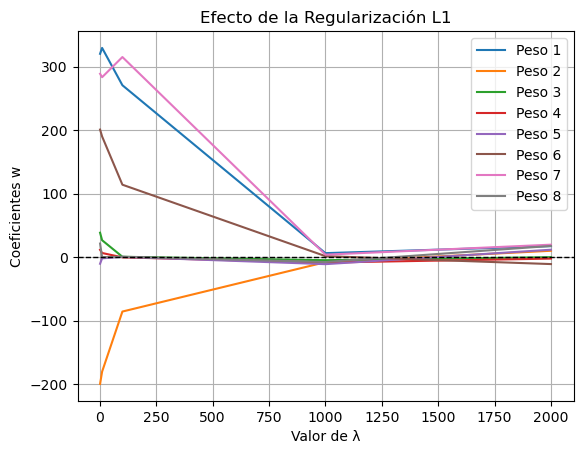

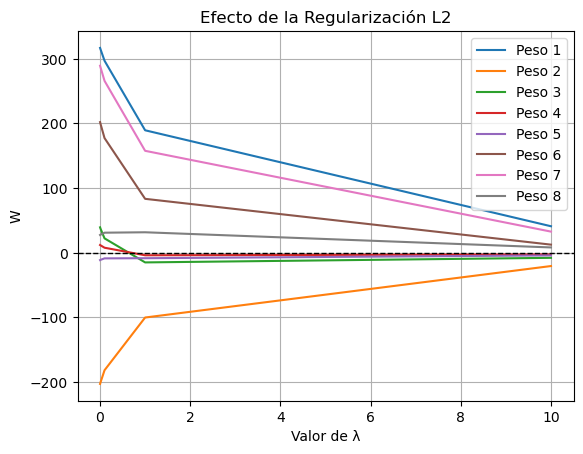

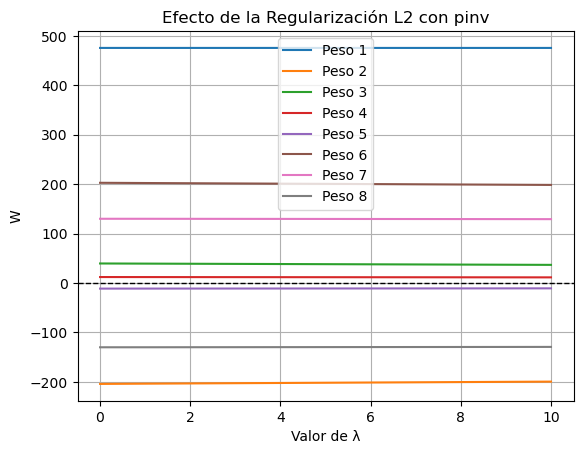

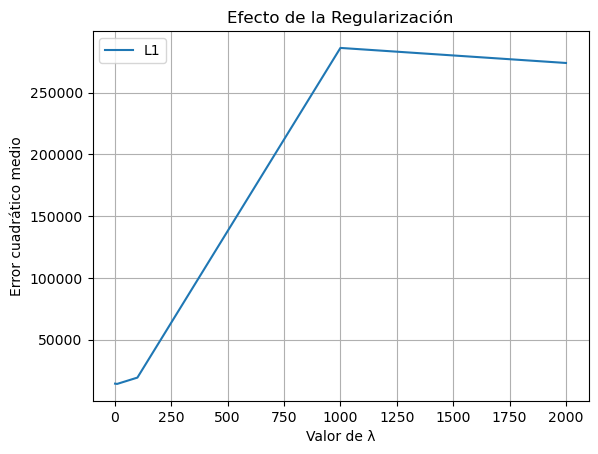

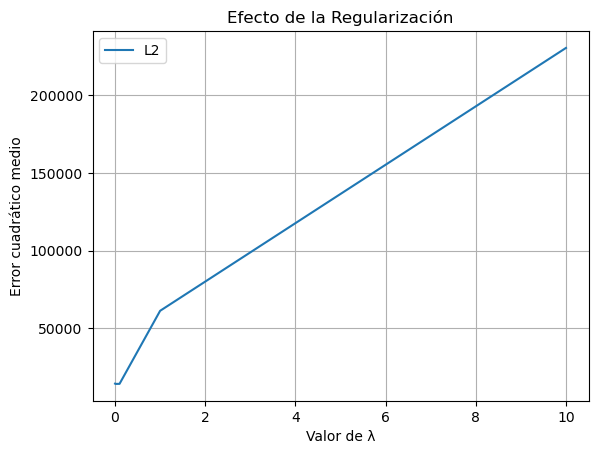

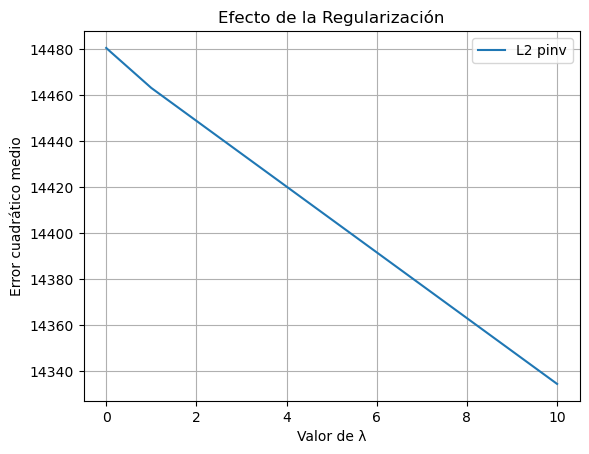

In [22]:
#implementamos regularizacion


w_values_l1 = []
w_values_l2 = []
w_values_l2_pinv = []
mse_values_l1 = []
mse_values_l2 = []
mse_values_l2_pinv = []
lambda_values_l1 = [ 1, 10, 100, 1000, 2000]
lambda_values_l2 = [ 0.001, 0.01, 0.1, 1, 10]
X_train = df_train_fe.drop(columns=['price']).values
Y_train = df_train_fe['price'].values
X_val = df_val_fe.drop(columns=['price']).values
Y_val = df_val_fe['price'].values


for lambda_val in lambda_values_l1:
    model = LinearReg(X_train, Y_train, lambda_val, lambda_val)
    model.train_gd(0.01, 1000, "l1")
    w_values_l1.append(model.W) #accedo directamente a w pero puedo hacer nuevo metodo get
    predict = model.predict(X_val)
    mse_values_l1.append(model.mean_squared_error(Y_val, predict))
    
for lambda_val in lambda_values_l2:
    model = LinearReg(X_train, Y_train, lambda_val, lambda_val)
    model.train_gd(0.01, 1000, "l2")
    w_values_l2.append(model.W)
    predict = model.predict(X_val)
    mse_values_l2.append(model.mean_squared_error(Y_val, predict))
    
for lambda_val in lambda_values_l2:
    model = LinearReg(X_train, Y_train, lambda_val, lambda_val)
    model.train_pinv("l2")
    w_values_l2_pinv.append(model.W)
    predict = model.predict(X_val)
    mse_values_l2_pinv.append(model.mean_squared_error(Y_val, predict))

w_values = np.array(w_values_l1)
for i in range(w_values.shape[1]):
    plt.plot(lambda_values_l1, w_values[:, i], label=f'Peso {i+1}')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Valor de λ')
plt.ylabel('Coeficientes w')
plt.title(f'Efecto de la Regularización L1')
plt.legend()
plt.grid(True)
plt.show()

w_values = np.array(w_values_l2)

for i in range(w_values.shape[1]):
    plt.plot(lambda_values_l2, w_values[:, i], label=f'Peso {i+1}')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Valor de λ')
plt.ylabel('W')
plt.title(f'Efecto de la Regularización L2')
plt.legend()
plt.grid(True)
plt.show()

w_values = np.array(w_values_l2_pinv)

for i in range(w_values.shape[1]):
    plt.plot(lambda_values_l2, w_values[:, i], label=f'Peso {i+1}')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Valor de λ')
plt.ylabel('W')
plt.title(f'Efecto de la Regularización L2 con pinv')
plt.legend()
plt.grid(True)
plt.show()


plt.plot(lambda_values_l1, mse_values_l1, label='L1')
plt.xlabel('Valor de λ')
plt.ylabel('Error cuadrático medio')
plt.title(f'Efecto de la Regularización')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(lambda_values_l2, mse_values_l2, label='L2')
plt.xlabel('Valor de λ')
plt.ylabel('Error cuadrático medio')
plt.title(f'Efecto de la Regularización')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(lambda_values_l2, mse_values_l2_pinv, label='L2 pinv')
plt.xlabel('Valor de λ')
plt.ylabel('Error cuadrático medio')
plt.title(f'Efecto de la Regularización')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# podemos observar que la regularizacion ayuda a que los pesos no se disparen y a que el modelo generalice mejor y viendo l1 contra l2 podemos ver que l2 es mas suave y no pone los pesos en 0 como l1

X_train = df_train_fe.drop(columns=['price']).values
Y_train = df_train_fe['price'].values
Y_val = df_val_fe['price'].values
X_val = df_val_fe.drop(columns=['price']).values
model = LinearReg(X_train, Y_train, 0, 0.1)
model.train_gd(0.1,1000,"l2")
w=model.print_W(feature_names)
predict = model.predict(X_val)
print("el mse es de: ",model.mean_squared_error(Y_val, predict))

#l2 ayuda al moddelo a que los parametros no crezcan mucho y se ajusten mucho a los datos de entrenamiento, aparte l2 mantiene valores de los pesos y no los manda a o como l1

bias: 297.00887711544823
area: -181.62822477885092
is_house: 22.32013441409287
has_pool: 7.868883865938946
age: -8.61159500469555
rooms: 177.40415005532083
lat_bin: 265.8657604075315
lon_bin: 31.143116707916136
el mse es de:  14339.800047018965


In [24]:
best_lambda = lambda_values_l2[np.argmin(mse_values_l2)]
print("el mejor lambda es: ",best_lambda)

model = LinearReg(X_train, Y_train, 0, best_lambda)
model.train_gd(0.1,1000,"l2")
w=model.print_W(feature_names)
predict = model.predict(X_val)
print("el mse es de: ",model.mean_squared_error(Y_val, predict))

#se logro una mejoria en el mse con el mejor lambda

el mejor lambda es:  0.01
bias: 314.9227285084255
area: -201.24539589033094
is_house: 37.45687406185631
has_pool: 11.611558500015546
age: -10.911258347421589
rooms: 199.80085104423733
lat_bin: 286.31087766809264
lon_bin: 28.61185084033289
el mse es de:  14287.265633782607


/home/manurrell/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Lambda: 0.0001, MSE: 16313.600668194855
Lambda: 0.001, MSE: 16311.76125181311
Lambda: 0.01, MSE: 16322.618276051817
Lambda: 0.1, MSE: 18428.48796808274
Lambda: 1, MSE: 81040.86378132249


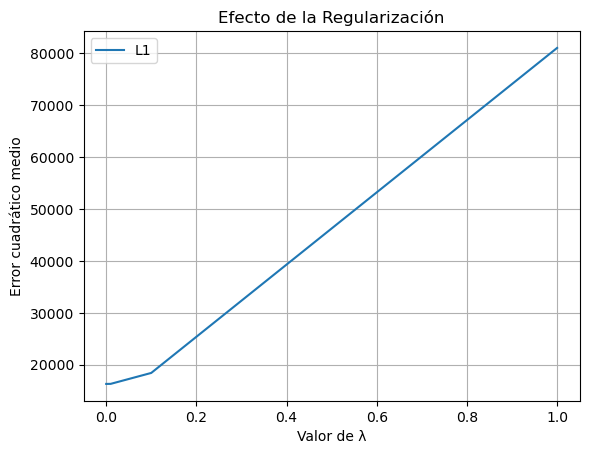

In [25]:
# buscamos el mejor lambda con cross validation
k_folds = 5
lambdas = [0.0001, 0.001, 0.01, 0.1, 1]
mse_means = []

dfs = np.array_split(df_train_fe, k_folds)



for lambda_val in lambdas:
    mse_values = []
    for k in range(k_folds):
        df_val_cv = dfs[k]
        df_train_cv = df_train_fe.drop(df_val_cv.index)
        X_train_cv = df_train_cv.drop(columns=['price']).values
        Y_train_cv = df_train_cv['price'].values
        X_val_cv = df_val_cv.drop(columns=['price']).values
        Y_val_cv = df_val_cv['price'].values
        model = LinearReg(X_train_cv, Y_train_cv, 0, lambda_val)
        model.train_gd(0.1,1000,"l2")
        predict = model.predict(X_val_cv)
        mse_values.append(model.mean_squared_error(Y_val_cv, predict))
    print(f'Lambda: {lambda_val}, MSE: {np.mean(mse_values)}')
    mse_means.append(np.mean(mse_values))
    
plt.plot(lambdas,mse_means , label='L1')
plt.xlabel('Valor de λ')
plt.ylabel('Error cuadrático medio')
plt.title(f'Efecto de la Regularización')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_test = pd.read_csv("../data/raw/casas_test.csv")
dp_test = Dataprocessor(df_test)
dp_test.set_area_units()
dp_test.handle_missing_values()
df_test_p = dp_train.normalize_new_data(dp_test.get_data())

df_dev_p["lat_bin"] = np.where(df_dev_p["lat"] >= 0, 1, 0)
df_test_p["lat_bin"] = np.where(df_test_p["lat"] >= 0, 1, 0)
df_dev_p["lon_bin"] = np.where(df_dev_p["lon"] >= 0, 1, 0)
df_test_p["lon_bin"] = np.where(df_test_p["lon"] >= 0, 1, 0)

df_dev_p = df_dev_p.drop(columns=["lat"])
df_test_p = df_test_p.drop(columns=["lat"])
df_dev_p = df_dev_p.drop(columns=["lon"])
df_test_p = df_test_p.drop(columns=["lon"])

#save the data
df_dev_p.to_csv("../data/processed/casas_dev.csv", index=False)
df_test_p.to_csv("../data/processed/casas_test.csv", index=False)


#agregar fe a dev y test

In [ ]:
# de todos los modelos y variaciones implementados el que mejor capacidad predictiva tiene fue el modelo de gd con regularizacion l2 y lambda 0.001
# ahora voy a entrenar con todo dev y predecir con 


X_train = df_dev_p.drop(columns=['price']).values
Y_train = df_dev_p['price'].values
X_val = df_test_p.drop(columns=['price']).values
Y_val = df_test_p['price'].values
model = LinearReg(X_train, Y_train, 0, 0.001)
model.train_gd(0.01,1000,"l2")
w=model.print_W(feature_names)
predict = model.predict(X_val)
print("el mse es de: ",model.mean_squared_error(Y_val, predict))
print("el rmse es de: ",model.rmse(Y_val, predict))

bias: 314.5590269406049
area: 130.82569551376028
is_house: 33.608754486213414
has_pool: 13.594136732831192
age: -11.900405436104908
rooms: 18.388738469205506
lat_bin: 461.5413993539863
lon_bin: -146.9823724133824
el mse es de:  26655.634586092634
el rmse es de:  163.26553398097417
